In [1]:
%load_ext autoreload
%autoreload 2
%aimport -sympy

In [2]:
# %reload_ext

In [38]:
from src.planttraits.datasets.plant_traits_dataset import PlantTraitsDataset
from src.planttraits.models.example_model import PTNN, kwargs
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch 
import matplotlib.pyplot as plt
import os 
from pathlib import Path 

In [4]:
train_dataset = PlantTraitsDataset()
test_dataset = PlantTraitsDataset(preprocessors=train_dataset.return_preprocessors())

### Modis Vod

In [5]:
preps = train_dataset.return_preprocessors()
modis_prep = preps['modis_vod']
cols = modis_prep.columns
train_modis = train_dataset.data[cols]
display(train_modis.head())

,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12,...,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m3,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m4,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m5,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m6,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m7,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m8,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m9,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m10,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m11,MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m12
id,,,,,,,,,,,,,,,,,,,,,
191255167,0.959629,1.690024,-0.290565,-0.902835,1.010520,-0.731333,-1.048512,0.668641,-0.993454,0.803626,...,0.599221,0.368827,0.861548,1.476500,1.573498,1.562217,1.395835,0.916068,0.598678,1.606683
196514232,-1.032520,0.099913,-0.505470,0.031727,1.146085,0.263241,-0.307446,0.584049,0.107196,-0.848648,...,0.482524,0.862181,1.272051,1.607151,1.587361,1.376091,1.300722,1.159873,0.699125,0.271107
149966009,0.433492,-0.556455,0.476111,0.955727,-0.793090,0.293944,0.710250,-0.552695,0.296227,0.390543,...,-1.027013,-1.080839,-1.175863,-1.396041,-1.316599,-1.265784,-1.038624,-0.955819,-0.800274,-0.842282
195623599,-0.115828,-0.342053,0.284719,0.799157,0.066389,0.490414,0.501150,-0.198139,0.478483,0.111713,...,-0.206579,0.012833,0.270764,0.524416,0.474792,0.337906,0.161839,-0.090589,-0.282341,-0.428372
183372069,-0.240557,0.042857,0.032672,-0.467565,0.636635,-0.581598,-0.064493,0.343358,-0.046194,-0.122527,...,-0.101625,0.044161,0.189780,0.238188,0.370198,0.457474,0.526075,0.465631,0.309488,0.125340


In [6]:
print(train_modis.columns.tolist())

['MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m

In [7]:
test_col = f"MODIS_2000.2020_monthly_mean_surface_reflectance_band_14_._month_m10"

if test_col in train_modis.columns:
    print("Istnieje")
else:
    print("Nie istnieje")


Istnieje


### Soil

In [8]:
preps = train_dataset.return_preprocessors()
soil_prep = preps['soil']
cols = soil_prep.columns

In [9]:
cols

['SOIL_bdod_0.5cm_mean_0.01_deg',
 'SOIL_bdod_100.200cm_mean_0.01_deg',
 'SOIL_bdod_15.30cm_mean_0.01_deg',
 'SOIL_bdod_30.60cm_mean_0.01_deg',
 'SOIL_bdod_5.15cm_mean_0.01_deg',
 'SOIL_bdod_60.100cm_mean_0.01_deg',
 'SOIL_cec_0.5cm_mean_0.01_deg',
 'SOIL_cec_100.200cm_mean_0.01_deg',
 'SOIL_cec_15.30cm_mean_0.01_deg',
 'SOIL_cec_30.60cm_mean_0.01_deg',
 'SOIL_cec_5.15cm_mean_0.01_deg',
 'SOIL_cec_60.100cm_mean_0.01_deg',
 'SOIL_cfvo_0.5cm_mean_0.01_deg',
 'SOIL_cfvo_100.200cm_mean_0.01_deg',
 'SOIL_cfvo_15.30cm_mean_0.01_deg',
 'SOIL_cfvo_30.60cm_mean_0.01_deg',
 'SOIL_cfvo_5.15cm_mean_0.01_deg',
 'SOIL_cfvo_60.100cm_mean_0.01_deg',
 'SOIL_clay_0.5cm_mean_0.01_deg',
 'SOIL_clay_100.200cm_mean_0.01_deg',
 'SOIL_clay_15.30cm_mean_0.01_deg',
 'SOIL_clay_30.60cm_mean_0.01_deg',
 'SOIL_clay_5.15cm_mean_0.01_deg',
 'SOIL_clay_60.100cm_mean_0.01_deg',
 'SOIL_nitrogen_0.5cm_mean_0.01_deg',
 'SOIL_nitrogen_100.200cm_mean_0.01_deg',
 'SOIL_nitrogen_15.30cm_mean_0.01_deg',
 'SOIL_nitrogen_30.60c

In [10]:
len(cols)

61

### Worldclim Bio

In [11]:
preps = train_dataset.return_preprocessors()
worldclim_prep = preps['worldclimbio']
cols = worldclim_prep.selected_columns

In [12]:
cols

['WORLDCLIM_BIO1_annual_mean_temperature',
 'WORLDCLIM_BIO12_annual_precipitation',
 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
 'WORLDCLIM_BIO15_precipitation_seasonality',
 'WORLDCLIM_BIO4_temperature_seasonality']

### Images

In [13]:
train_img = train_dataset.img_preprocessor.transform(r"C:\Users\julia\VSCode\plant-traits-2024\data\train_images\26375.jpeg")
train_img.shape

torch.Size([3, 256, 256])

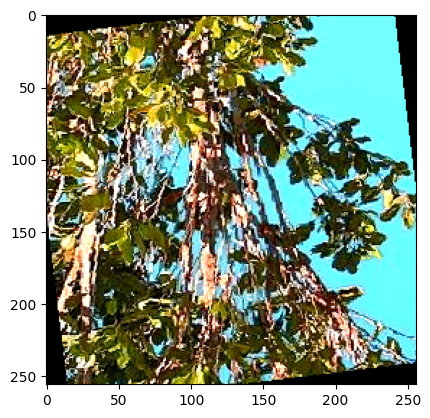

In [14]:
plt.imshow(train_img.numpy().transpose(1, 2, 0))

### All Dataset

In [15]:
len(train_dataset)

47013

In [16]:
len(test_dataset)

6545

In [17]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [18]:
img, modisvod_row, soil_row, worldclimbio_row, std_row, mean_row = next(iter(train_loader))
# img, modisvod_row, soil_row, worldclimbio_row, std_row, mean_row = next(iter(test_loader))

In [19]:
img.shape

torch.Size([1, 3, 256, 256])

In [20]:
img

tensor([[[[0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          ...,
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418]],

         [[0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          ...,
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418]],

         [[0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0

In [21]:
modisvod_row

tensor([[ 0.9596,  1.6900, -0.2906, -0.9028,  1.0105, -0.7313, -1.0485,  0.6686,
         -0.9935,  0.8036,  1.7063, -0.3233,  0.7849,  1.5886, -0.4851, -0.9588,
          0.7449, -1.4201, -0.9551,  0.3989, -0.9047, -0.5708,  0.9321, -0.6111,
         -0.4401,  1.5984, -0.4429, -0.5198,  1.7966, -0.3912, -0.4299,  1.7741,
         -0.2137, -0.5426,  1.6088, -0.3925, -1.2558, -1.2267, -1.0715, -0.9952,
         -1.2612, -0.9744, -1.2293, -1.0042,  1.6066,  1.4951,  0.5992,  0.3688,
          0.8615,  1.4765,  1.5735,  1.5622,  1.3958,  0.9161,  0.5987,  1.6067]])

In [22]:
soil_row

tensor([[ 0.2083,  0.3684,  0.1429,  0.3684,  0.1739,  0.4500,  0.6327,  1.2113,
          1.5584,  1.5753,  1.2561,  1.3380,  0.5789,  0.0291,  0.3596,  0.1649,
          0.4588,  0.1165,  0.6786,  0.3554,  0.7568,  0.5246,  0.6759,  0.4435,
          0.4613,  2.1205,  0.7120,  1.3571,  0.1818,  2.0988, -0.3679,  0.3553,
         -0.2301,  0.0353, -0.2695,  0.2533, -0.4286,  1.0714,  1.1250,  1.1333,
          1.1333,  1.1429,  1.2000, -0.4292, -0.5829, -0.5426, -0.5190, -0.4487,
         -0.5490,  0.2921,  0.5287,  0.3143,  0.3448,  0.3034,  0.4217,  0.3229,
          3.3609,  2.0442,  2.6853,  0.5819,  2.5116]])

In [23]:
worldclimbio_row

tensor([[-0.5963, -0.7073, -0.6248, -0.6348,  1.9048]])

In [24]:
std_row, mean_row

(tensor([[0., 0., 0., 0., 0., 0.]]),
 tensor([[0.5171, 2.2988, 0.2738, 1.1201, 1.3388, 5.7032]]))

In [25]:
torch.concat([modisvod_row, soil_row, worldclimbio_row], axis=1).shape

torch.Size([1, 122])

In [26]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [27]:
kwargs

{'n_feat': 122,
 'backbone_net': EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): S

In [28]:
import torchvision

In [29]:
efficientnet_b2 = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')

In [30]:
efficientnet_b2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [34]:
efficientnet_b2.classifier = torch.nn.Identity()

In [36]:
efficientnet_b2(torch.rand((2, 3, 256, 256))).shape

torch.Size([2, 1408])

In [39]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [40]:
resnet18.fc = torch.nn.Identity()

In [41]:
kwargs['backbone_net'] = resnet18

In [42]:
kwargs

{'n_feat': 122,
 'backbone_net': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [45]:
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'test-model'
logger = TensorBoardLogger(save_dir='./tnsr-logs', name=model_name)
# checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
#                                       monitor='val_loss', save_last=True) 
# early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

model = PTNN(**kwargs)
trainer = pl.Trainer(max_epochs=1, fast_dev_run=False, default_root_dir=checkpoint_dir / model_name, logger=logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1 min - 33

In [ ]:
trainer.fit(model, train_dataloaders=train_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | climate_encoder | Sequential | 785 K  | train
1 | img_encoder     | Sequential | 11.3 M | train
2 | prediction_head | Sequential | 66.7 K | train
-------------------------------------------------------
984 K     Trainable params
11.2 M    Non-trainable params
12.2 M    Total params
48.643    Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

In [146]:
model

PTNN(
  (climate_encoder): Sequential(
    (0): Linear(in_features=122, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1000, bias=True)
    (7): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=1000, out_features=512, bias=True)
    (10): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (img_encoder): Sequential(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0

In [147]:
preds = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [148]:
preds = torch.concat(preds)

In [149]:
test_dataset.transform_predictions(preds)

tensor([[ 0.6244,  0.1660,  0.4016,  0.2804,  0.2006, -0.2024],
        [ 1.0622, -0.0107,  0.0453,  0.8145,  0.2465, -0.0147],
        [ 0.8993, -0.0157,  0.2812,  0.3723,  0.1215,  0.0363],
        ...,
        [ 0.9777,  0.0290,  0.3286,  0.3862, -0.0768, -0.0798],
        [ 0.8208, -0.1715,  0.3177,  0.5575,  0.0876,  0.0137],
        [ 0.8728, -0.0405,  0.3916,  0.5290,  0.1526, -0.0858]])